In [ ]:
import numpy as np
import scipy

import librosa
import soundfile

import matplotlib.pyplot as plt
import IPython

In [ ]:
!wget -O "audio.mp3" "https://drive.google.com/uc?export=download&id=130sxwOMxiEOgB6Hkq4aEQ18Zxlyg9rPn"

# First task: Denoise the Audio File

In [ ]:
# A class to denoise the test audio in two different steps
# This class has two steps to denoise the audio, Since the test file has to class of noises: uniform and gaussian noises
class Denoiser:
    def __init__(self, file_path: str):
        self.audio, self.sample_rate = self.__load_audio_file(file_path)
        self.__update_audio_information(self.audio, self.sample_rate)

    def __load_audio_file(self, file_path: str):
        audio, s_rate = librosa.load(file_path, sr=None)
        return audio, s_rate

    def __update_audio_information(self, audio: np.ndarray, sample_rate: int):
        self.duration = audio.size / sample_rate
        self.time_array = np.arange(0, self.duration, 1. / sample_rate)
        self.audio_fft = self.__fast_fourier_transform()
        self.audio_fft_ampl = (2 * self.__magnitude_fft()) / audio.size
        self.audio_fft_freq = self.__dft_sample_frequency()

    def reload_audio_file(self, file_path: str):
        self.audio, self.sample_rate = self.__load_audio_file(file_path)
        self.__update_audio_information(self.audio, self.sample_rate)

    # Show Audio Waveform and Frequency-Amplitude plot
    def show_plots(self, suptitle: str, waveform_only=False):
        if waveform_only == True:
            plt.figure(figsize=(15,4))
            plt.plot(self.time_array, self.audio, linewidth=0.1)
            plt.title(f"{suptitle} - Audio Waveform")
            plt.xlabel("Time (seconds)")
            plt.ylabel("Amplitude (normalized audio)")
        else:
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))
            fig.suptitle(suptitle, fontsize=20)

            ax1.plot(self.time_array, self.audio, linewidth=0.05)
            ax1.set_title("Audio Waveform")
            ax1.set_xlabel("Time (seconds)")
            ax1.set_ylabel("Amplitude (normalized audio)")

            one_second = self.audio[:self.sample_rate // 10]
            ax2.plot(np.arange(0, 0.1, 1. / self.sample_rate), one_second, linewidth=0.2)
            ax2.set_title("Waveform for 0.1 second of audio")
            ax2.set_xlabel("Time (seconds)")
            ax2.set_ylabel("Amplitude (normalized audio)")

            ax3.plot(np.abs(self.audio_fft_freq), self.audio_fft_ampl, linewidth=0.05)
            ax3.set_title("Frequency - Amplitude")
            ax3.set_xlabel("Frequency (Hz)")
            ax3.set_ylabel("Amplitude")

            plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

    # Calculate Fast Fourier Transform
    def __fast_fourier_transform(self):
        return np.fft.fft(self.audio)

    # Calculate the magnitude of the signal with FFT
    def __magnitude_fft(self):
        return np.abs(self.__fast_fourier_transform())

    # Calculate Discrete Fourier Transform sample frequencies
    def __dft_sample_frequency(self):
        return np.fft.fftfreq(self.audio.size, 1. / self.sample_rate)

    # Calculate Power Spectral Density
    def __power_spectral_density(self):
        return (self.__magnitude_fft() ** 2) / self.audio.size

    # Calculate Short-time Fourier Transform
    def __stft(self, data, n_fft, hop_length, win_length):
        return librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

    # Calculate Inverse Short-time Fourier Transform
    def __istft(self, data, hop_length, win_length):
        return librosa.istft(data, hop_length, win_length)

    def __amp_to_db(self, data):
        return librosa.core.amplitude_to_db(data, ref=1.0, amin=1e-20, top_db=80.0)

    def __db_to_amp(self, data):
        return librosa.core.db_to_amplitude(data, ref=1.0)

    # Determine top n frequencies with higher amplitudes
    def print_top_n_frequencies(self, n: int):
        # Calculate Frequency Magnitude
        magnitudes = np.abs(self.audio_fft[np.where(self.audio_fft_freq >= 0)])
        # Get index of top n frequencies
        peak_frequency = np.sort((np.argpartition(magnitudes, -n)[-n:]) / self.duration)
        print(f"Top {n} frequencies with higher amplitudes:")
        print(peak_frequency)

    # Remove two beep tunes in frequencies of 440 and 1000 Hz
    def remove_noise_step1(self, export_name: str):
        order_of_filter = 8
        nyq = 0.5 * self.sample_rate  # Nyquist Frequency
        beep1_frequency, beep2_frequency = 440, 1000
        band1 = ((beep1_frequency - 15) / nyq, (beep1_frequency + 15) / nyq)  # (425/nyq, 455/nyq)
        band2 = ((beep2_frequency - 15) / nyq, (beep2_frequency + 15) / nyq)  # (985/nyq, 1015/nyq)

        sos = scipy.signal.butter(order_of_filter, band1, btype='bandstop', analog=False, output='sos')
        denoised_step1 = scipy.signal.sosfiltfilt(sos, self.audio)

        sos = scipy.signal.butter(order_of_filter, band2, btype='bandstop', analog=False, output='sos')
        denoised_step1 = scipy.signal.sosfiltfilt(sos, denoised_step1)

        if export_name is not None:
            soundfile.write(export_name, denoised_step1, self.sample_rate)
        return denoised_step1

    # Remove uniform white noise from the audio based upon a part of it containing only noise
    # idea of this step came from here: https://timsainburg.com/noise-reduction-python.html#noise-reduction-python
    def remove_noise_step2(self, export_name: str):
        step1 = self.remove_noise_step1('denoise_step1.wav')
        noise_sample = step1[int(0.1 * self.sample_rate):int(0.2 * self.sample_rate)]

        n_grad_freq = 2  # how many frequency channels to smooth over with the mask.
        n_grad_time = 4  # how many time channels to smooth over with the mask.
        n_fft = 2048     # length of the windowed signal after padding with zeros.
        win_length = 2048  # each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`.
        hop_length = 512  # number of audio samples between adjacent STFT columns.
        n_std_thresh = 2  # how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal

        # STFT over noise
        noise_stft = self.__stft(noise_sample, n_fft, hop_length, win_length)
        noise_stft_db = self.__amp_to_db(np.abs(noise_stft))  # convert to dB
        
        # Calculate statistics over noise
        mean_freq_noise = np.mean(noise_stft_db, axis=-1)
        std_freq_noise = np.std(noise_stft_db, axis=-1)
        noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh

        # STFT over signal
        sig_stft = self.__stft(step1, n_fft, hop_length, win_length)
        sig_stft_db = self.__amp_to_db(np.abs(sig_stft))

        # Calculate value to mask dB to
        mask_gain_dB = np.min(self.__amp_to_db(np.abs(sig_stft)))

        # Create a smoothing filter for the mask in time and frequency
        smoothing_filter = np.outer(
            np.concatenate(
                [
                    np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                    np.linspace(1, 0, n_grad_freq + 2),
                ]
            )[1:-1],
            np.concatenate(
                [
                    np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                    np.linspace(1, 0, n_grad_time + 2),
                ]
            )[1:-1],
        )
        smoothing_filter = smoothing_filter / np.sum(smoothing_filter)

        # calculate the threshold for each frequency/time bin
        db_thresh = np.repeat(
            np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
            np.shape(sig_stft_db)[1],
            axis=0).T

        # mask if the signal is above the threshold
        sig_mask = sig_stft_db < db_thresh

        # convolve the mask with a smoothing filter
        sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")

        # mask the signal
        sig_stft_db_masked = (
                sig_stft_db * (1 - sig_mask)
                + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
        )  # apply mask on real part
        sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)    # apply mask on imaginary part

        # add the masked parts together
        sig_stft_amp = (self.__db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (1j * sig_imag_masked)

        # recover the signal by inversing the STFT values
        recovered_signal = self.__istft(sig_stft_amp, hop_length, win_length)

        # write to file
        if export_name is not None:
            soundfile.write(export_name, recovered_signal, self.sample_rate)

        return recovered_signal

    # A method function to call the denoising procedure's functions
    def denoise(self):
        return self.remove_noise_step2('denoised_audio.wav')


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


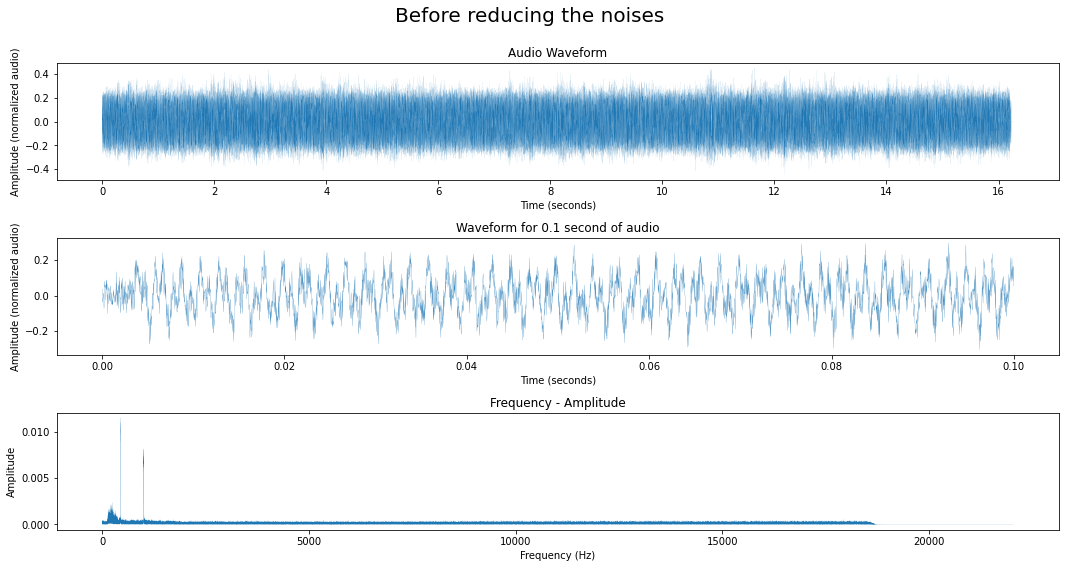

Top 100 frequencies with higher amplitudes:
[ 440.20404323  440.26550708  440.32697092  440.38843476  440.44989861
  440.51136245  440.57282629  440.63429013  440.69575398  440.75721782
  440.81868166  440.88014551  440.94160935  441.00307319  441.06453704
  441.12600088  441.18746472  441.24892856  441.31039241  441.37185625
  441.43332009  441.49478394  441.55624778  441.61771162  441.67917546
  441.74063931  441.80210315  441.86356699  441.92503084  441.98649468
  442.04795852  442.10942237  442.17088621  442.23235005  442.29381389
  442.35527774  442.41674158  442.47820542  442.53966927  442.60113311
  442.66259695  442.72406079  442.78552464  442.84698848  442.90845232
  442.96991617  443.03138001  443.09284385  443.1543077   443.21577154
  443.27723538  443.33869922  443.40016307  443.46162691  443.52309075
  443.5845546   443.64601844  443.70748228  443.76894613  443.83040997
  443.89187381  443.95333765  444.0148015   444.07626534  444.13772918
  444.19919303  444.26065687  444

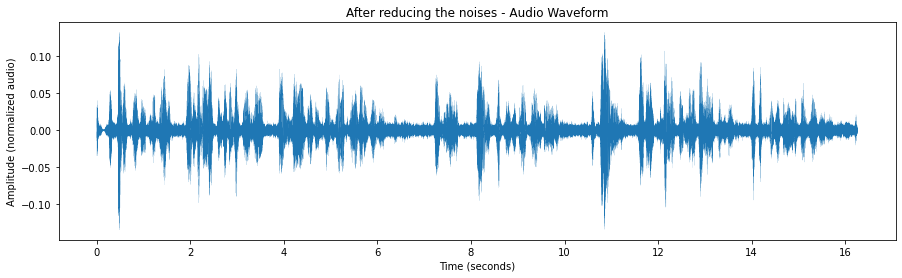

In [ ]:
# Define an object using Denoiser class and try to denoise "audio.mp3" file
noise_reduction_object = Denoiser("audio.mp3")
noise_reduction_object.show_plots("Before reducing the noises")  # show plots

noise_reduction_object.print_top_n_frequencies(100)

noise_reduction_object.denoise()  # call main denoiser method function

# Load the denoised file in the object to show its waveform
noise_reduction_object.reload_audio_file('denoised_audio.wav')
noise_reduction_object.show_plots("After reducing the noises", waveform_only=True)  # show plots after denoising

## Play original and denoised audio files

Original audio:

In [ ]:
original, original_sr = librosa.load("audio.mp3", sr=None)
IPython.display.Audio(data=original, rate=original_sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Result from first step of denoising:

In [ ]:
denoise_step1, denoise_step1_sr = librosa.load("denoise_step1.wav", sr=None)
IPython.display.Audio(data=denoise_step1, rate=denoise_step1_sr)

Final denoised audio:

In [ ]:
denoised_audio, denoised_audio_sr = librosa.load("denoised_audio.wav", sr=None)
IPython.display.Audio(data=denoised_audio, rate=denoised_audio_sr)

# Second task: Convert the Female Voice to Male Voice

In [ ]:
# Function to Convert the female voice in the audio
# using naive pitch-shifting approach to convert male speech to female
def voice_converter(input_audio = 'denoised_audio.wav', export_path='male_voice.wav'):
    audio, audio_sr = librosa.load(input_audio, sr=None)
    male_voice = librosa.effects.pitch_shift(audio, audio_sr, n_steps=-7)

    soundfile.write(file=export_path, data=male_voice, samplerate=audio_sr)

    return male_voice, audio_sr


converted_voice, audio_sr = voice_converter('denoised_audio.wav')
IPython.display.Audio(data=converted_voice, rate=audio_sr)